In [126]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [178]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

In [179]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

## Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [180]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    if feature_is_constant:
        derivative = 2 * (np.dot(errors, feature))
    else:
        derivative = 2 * (np.dot(errors,feature)) + 2 * l2_penalty * weight   
    return derivative

In [181]:
sales = pd.read_csv("~/Desktop/ML_Washington/WashingtonML/Regression/Week2/kc_house_data.csv")

In [182]:
## To test the feature run the following:

(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False))
print (np.sum(errors*example_features[:,1])*2+20.)
print ('')

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True))
print (np.sum(errors)*2.)

-56554166815950.0
-56554166815950.0

-22446749330.0
-22446749330.0


## Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [183]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    print ('Starting gradient descent with l2_penalty = ' + str(l2_penalty))
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while iteration < max_iterations:
        iteration += 1  # increment iteration counter
        ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        ### === end code section ===
        
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        #print(errors.shape)
        # from time to time, print the value of the cost function
        if iteration%print_frequency==0:
            print ('Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2)))
        
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            # subtract the step size times the derivative from the current weight
            
            if i == 0:
                derivative = feature_derivative_ridge(errors, feature_matrix[:,i],weights[i],l2_penalty,True)
            else:
                derivative = feature_derivative_ridge(errors, feature_matrix[:,i],weights[i],l2_penalty,False)
            weights[i] = weights[i] - step_size * derivative
            
    print ('Done with gradient descent at iteration ', iteration)
    print ('Learned weights = ', str(weights))
    return weights

## Visualizing effect of L2 penalty

In [184]:
simple_features = ['sqft_living']
my_output = 'price'

In [185]:
train_data = pd.read_csv('kc_house_train_data.csv')
test_data = pd.read_csv('kc_house_test_data.csv')

In [186]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

In [187]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

In [188]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights,
                                                             step_size, 0, 1000)

Starting gradient descent with l2_penalty = 0
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  5394267213533688.0
Iteration = 3
Cost function =  4023237736286403.0
Iteration = 4
Cost function =  3101256183295487.0
Iteration = 5
Cost function =  2481247643601012.0
Iteration = 6
Cost function =  2064308076801446.5
Iteration = 7
Cost function =  1783927096156441.2
Iteration = 8
Cost function =  1595378201854741.8
Iteration = 9
Cost function =  1468583989698184.0
Iteration = 10
Cost function =  1383318190090050.5
Iteration = 20
Cost function =  1211562139024524.5
Iteration = 30
Cost function =  1208313761205656.2
Iteration = 40
Cost function =  1208252324779675.5
Iteration = 50
Cost function =  1208251162139724.8
Iteration = 60
Cost function =  1208251139442068.0
Iteration = 70
Cost function =  1208251138303840.5
Iteration = 80
Cost function =  1208251137573361.5
Iteration = 90
Cost function =  1208251136850594.0
Iteration = 100
Cost function =  120825113612

In [189]:
print(round(263.024,1))

263.0


In [190]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights,
                                                             step_size, 1e11 , 1000)

Starting gradient descent with l2_penalty = 100000000000.0
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  5618303898910948.0
Iteration = 3
Cost function =  4920613278301801.0
Iteration = 4
Cost function =  4652381942678797.0
Iteration = 5
Cost function =  4549258764034560.0
Iteration = 6
Cost function =  4509612390884944.0
Iteration = 7
Cost function =  4494370050276984.0
Iteration = 8
Cost function =  4488509984023467.5
Iteration = 9
Cost function =  4486256988524010.0
Iteration = 10
Cost function =  4485390752666539.5
Iteration = 20
Cost function =  4484848868025912.0
Iteration = 30
Cost function =  4484847880470641.5
Iteration = 40
Cost function =  4484846931073275.0
Iteration = 50
Cost function =  4484845981678999.5
Iteration = 60
Cost function =  4484845032285122.0
Iteration = 70
Cost function =  4484844082891644.0
Iteration = 80
Cost function =  4484843133498563.5
Iteration = 90
Cost function =  4484842184105884.0
Iteration = 100
Cost function = 

In [191]:
print(round(124.57217567,1))

124.6


## Analysis of the shape and the dot product involved in calculating the derivative

In [192]:
simple_feature_matrix.shape

(17384, 2)

In [193]:
np.dot(simple_feature_matrix[:1], initial_weights[1])

array([[0., 0.]])

In [194]:
predictions = predict_output(simple_feature_matrix, initial_weights)
predictions

array([0., 0., 0., ..., 0., 0., 0.])

In [195]:
errors = predictions - output
errors.shape

(17384,)

In [196]:
simple_feature_matrix[:,1]

array([1180, 2570,  770, ..., 1530, 1600, 1020])

In [197]:
np.dot(simple_feature_matrix[:,1], errors)

-23666256853232.0

This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

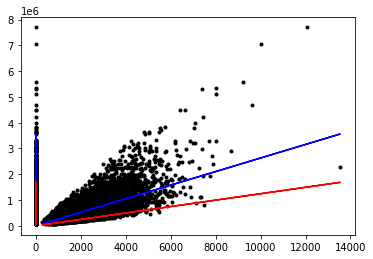

In [198]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

In [199]:
def rss(feature_matrix, weights, output):
    predictions = predict_output(feature_matrix, weights)
    residuals = predictions - output
    rss = sum(value ** 2 for value in residuals)
    return rss

In [200]:
test_rss_0_weight = rss(simple_test_feature_matrix, [0,0], test_output)
test_rss_no_regularization = rss(simple_test_feature_matrix, simple_weights_0_penalty , test_output)
test_rss_high_regularization = rss(simple_test_feature_matrix, simple_weights_high_penalty , test_output)

In [201]:
print(test_rss_0_weight,test_rss_no_regularization,test_rss_high_regularization)

1784273286136298.0 275723632153607.75 694642101489902.6


In [202]:
"{:.1E}".format((275723632153607.75))   ### To display the number in scientific notation

'2.8E+14'

# Running a multiple regression with L2 penalty

In [203]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

In [204]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

In [205]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights,
                                                             step_size, 0, max_iterations)

Starting gradient descent with l2_penalty = 0
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  4056752332045942.0
Iteration = 3
Cost function =  2529565114525310.0
Iteration = 4
Cost function =  1838556694300506.8
Iteration = 5
Cost function =  1525675575150296.5
Iteration = 6
Cost function =  1383789498571783.5
Iteration = 7
Cost function =  1319232606146273.5
Iteration = 8
Cost function =  1289648871879140.5
Iteration = 9
Cost function =  1275884723913736.5
Iteration = 10
Cost function =  1269278807397619.5
Iteration = 20
Cost function =  1257812386017016.0
Iteration = 30
Cost function =  1251954570861556.0
Iteration = 40
Cost function =  1246755422656425.8
Iteration = 50
Cost function =  1242139508166548.0
Iteration = 60
Cost function =  1238041400480994.0
Iteration = 70
Cost function =  1234403012742170.5
Iteration = 80
Cost function =  1231172774196731.5
Iteration = 90
Cost function =  1228304899227735.5
Iteration = 100
Cost function =  122575873838

In [206]:
print(round(243.05416982,1))

243.1


In [207]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights,
                                                             step_size, 1e11 , max_iterations)

Starting gradient descent with l2_penalty = 100000000000.0
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  4460489790922030.0
Iteration = 3
Cost function =  3796674469325300.5
Iteration = 4
Cost function =  3648319530880127.0
Iteration = 5
Cost function =  3615091103648369.0
Iteration = 6
Cost function =  3607602742943372.5
Iteration = 7
Cost function =  3605886322588677.5
Iteration = 8
Cost function =  3605474874959446.5
Iteration = 9
Cost function =  3605365168191211.0
Iteration = 10
Cost function =  3605329402609966.0
Iteration = 20
Cost function =  3605294281447483.0
Iteration = 30
Cost function =  3605293537691883.0
Iteration = 40
Cost function =  3605293083174690.0
Iteration = 50
Cost function =  3605292631531144.0
Iteration = 60
Cost function =  3605292179916288.0
Iteration = 70
Cost function =  3605291728301859.5
Iteration = 80
Cost function =  3605291276687575.0
Iteration = 90
Cost function =  3605290825073435.0
Iteration = 100
Cost function = 

In [208]:
print(round(91.48927365,1))

91.5


In [228]:
feature_matrix.sort()

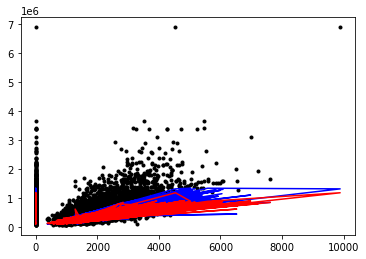

In [230]:
plt.plot(test_feature_matrix,test_output,'k.',
         test_feature_matrix,predict_output(test_feature_matrix, multiple_weights_0_penalty),'b-',
        test_feature_matrix,predict_output(test_feature_matrix, multiple_weights_high_penalty),'r-')

In [209]:
np.dot(test_feature_matrix,multiple_weights_0_penalty)

array([387465.47605824, 764977.14757579, 438709.53237955, ...,
       668981.48424192, 602473.88624925, 270778.00705338])

In [210]:
test_multiple_rss_0_weight = rss(test_feature_matrix, [0,0,0], test_output)
test_multiple_rss_no_regularization = rss(test_feature_matrix, multiple_weights_0_penalty , test_output)
test_multiple_rss_high_regularization = rss(test_feature_matrix, multiple_weights_high_penalty , test_output)

In [211]:
rss_multiple = [test_multiple_rss_0_weight,test_multiple_rss_no_regularization,test_multiple_rss_high_regularization]

In [212]:
print(rss_multiple)
min(rss_multiple)

[1784273286136298.0, 274067615918575.7, 500404800500840.7]


274067615918575.7

In [213]:
"{:.1E}".format((500404800500840.7))   ### To display the number in scientific notation

'5.0E+14'

In [214]:
test_feature_matrix[0]

array([   1, 1430, 1780])

In [215]:
house_1_no_regularization = predict_output(test_feature_matrix[0],multiple_weights_0_penalty)

In [216]:
print("Predicted Value = {}, Actual Price = {}, Diff = {}"
      .format(house_1_no_regularization, test_output[0], house_1_no_regularization - test_output[0]))

Predicted Value = 387465.47605823533, Actual Price = 310000.0, Diff = 77465.47605823533


In [217]:
house_1_high_regularization = predict_output(test_feature_matrix[0],multiple_weights_high_penalty)

In [218]:
print("Predicted Value = {}, Actual Price = {}, Diff = {}"
      .format(house_1_high_regularization, test_output[0], house_1_high_regularization - test_output[0]))

Predicted Value = 270453.53032194055, Actual Price = 310000.0, Diff = -39546.46967805945
